In [1]:
using Test
using StatsBase
using Distributions
using Plots
using FFTW


(process:7692): GLib-GIO-WARNING **: 12:37:45.323: Unexpectedly, UWP app `D5BE6627.UltraZipOpener_2.0.6.0_neutral__9pm2v9747qaaa' (AUMId `D5BE6627.UltraZipOpener_9pm2v9747qaaa!App') supports 127 extensions but has no verbs

(process:7692): GLib-GIO-WARNING **: 12:37:45.574: Unexpectedly, UWP app `KDEe.V.Okular_22.801.1132.0_x64__7vt06qxq7ptv8' (AUMId `KDEe.V.Okular_7vt06qxq7ptv8!KDEe.V.Okular') supports 5 extensions but has no verbs

(process:7692): GLib-GIO-WARNING **: 12:37:45.605: Unexpectedly, UWP app `Clipchamp.Clipchamp_2.5.0.0_neutral__yxz26nhyzhsrt' (AUMId `Clipchamp.Clipchamp_yxz26nhyzhsrt!App') supports 41 extensions but has no verbs


# Empirical distribution

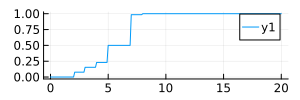

In [2]:
observations = [2.1, 3, 4, 5, 7, 8]
weights = Weights([1, 1, 1, 3.5, 6.3, 0.2])
empirical_distribution = ecdf(observations; weights)
xs = [i for i in 0:0.1:20]
ys = [empirical_distribution(x) for x in xs]
plot(xs,ys, size = (300, 100))

# Convolution of two distributions, FFT

In [3]:
function slow_convolution(v_1, v_2)
    for x in base_points_1
        l = div(x, step)
        tot = 0
        for i in 0:(l-1)
            tot += v_1[i + 1] * v_2[l-i]
        end
        push!(convolution, tot)
    end
    return convolution
end

slow_convolution (generic function with 1 method)

In [4]:
function fft_conv(d_1, d_2, limit)
    q = max(quantile(d_1, 1-limit), quantile(d_2, 1-limit))
    print(q)
    grid = 0:1:round(q)
    vector_values_1 = [pdf(d_1, x) for x in grid]
    vector_values_2 = [pdf(d_2, x) for x in grid]
    vector_conv = real(ifft(fft(vector_values_1).*fft(vector_values_2)))
    weights = Weights(vector_conv)
    return ecdf(grid; weights)
end

fft_conv (generic function with 1 method)

2000

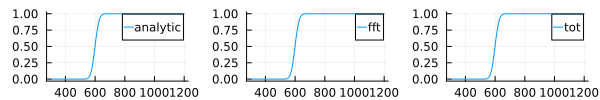

In [5]:
# standard convolution
b_1, b_2 = Binomial(1000, 0.2), Binomial(2000, 0.2)
cv_analytic = convolve(b_1, b_2)
cv_fft = fft_conv(b_1, b_2, 1e-30)
xs_test = 300:1200
p_analytic = plot(xs_test, [cdf(cv_analytic, x) for x in xs_test])
p_fft = plot(xs_test, [cv_fft(x) for x in xs_test])
p_tot = plot(xs_test, [cdf(Binomial(3000, 0.2), x) for x in xs_test])
plot(p_analytic, p_fft, p_tot, layout = (1, 3), size = (600, 100), label=["analytic" "fft" "tot"])

14881.002675202342

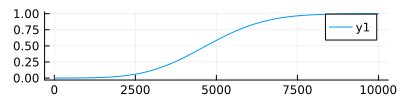

In [6]:
stp = 25
base_points = 0:stp:10000
conv = fft_conv(Gamma(100, 100), Gamma(80, 120), 0.00001)
plot(base_points, [conv(x) for x in base_points], size = (400, 100))

# Frequency-severity model

In [7]:
struct FrequencySeverity
    frequency
    severity
end

In [8]:
function StatsBase.rand(fs::FrequencySeverity)::Real
    tot = 0
    f = rand(fs.frequency)
    if f == 0 return 0 end
    for i in 1:f
        tot += rand(fs.severity)
    end
    return tot
end

function StatsBase.rand(fs::FrequencySeverity, n::Int)
    return [StatsBase.rand(fs) for x in 1:n]
end

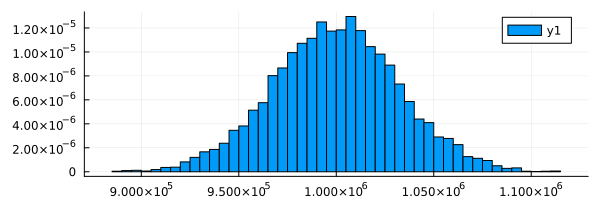

In [9]:
example_frequency = Poisson(1000)
example_severity = Gamma(100, 10)
ex_d = FrequencySeverity(example_frequency, example_severity)
draws = rand(ex_d, 10_000)
histogram(draws, norm = true, size = (600, 200))

### Define moment-generating function for complex values

In [13]:
function Distributions.mgf(d::Poisson, t::Complex)
    λ = rate(d)
    return exp(λ * (exp(t) - 1))
end

### Apply FFT

In [11]:
α = 100
θ = 10
λ = 1000
fs = FrequencySeverity(Poisson(λ), Gamma(α, θ))
e_end = 2_000_000
step_pdf = cdf.(fs.severity, 1:(e_end - 1)) .- cdf.(fs.severity, 0:(e_end - 2))
severity_ft = fft(step_pdf)
total_claim_amount_ft = mgf.(fs.frequency, log.(severity_ft))
convolution_fs = real(ifft(total_claim_amount_ft))

1999999-element Vector{Float64}:
 6.572801147937657e-19
 6.57793593199394e-19
 6.562392801877623e-19
 6.566833696196571e-19
 6.562392801877623e-19
 6.576409374571801e-19
 6.572523592042723e-19
 6.55649473911027e-19
 6.574744039202196e-19
 6.567388807986439e-19
 6.573425648701258e-19
 6.567527585933906e-19
 6.568845976434843e-19
 ⋮
 6.561890816020769e-19
 6.56591862910546e-19
 6.567728163436105e-19
 6.565823219266576e-19
 6.569469392995731e-19
 6.568865492083707e-19
 6.56906498538319e-19
 6.568290864644975e-19
 6.565926218524461e-19
 6.566506266976765e-19
 6.572367466851822e-19
 6.576994844037678e-19

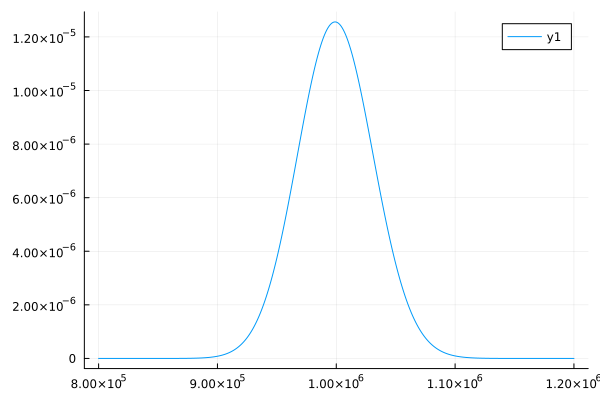

In [12]:
observation_plot = plot()
plot!(800_000:1000:1_200_000, convolution_fs[800_000:1000:1_200_000])
display(observation_plot)

## How to determine the domain of plot?

### Panjer Algorithm